In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 14

In [2]:
walkers = ['walkerA', 'walkerB', 'walkerC', 'walkerD', 'walkerE']
data = pd.read_csv(f'../data/processed/bk_input_data.csv', index_col=0)

bk_data = data.drop(['label'], axis=1).query(f'index.str.contains("BK")', engine='python').values
correct_data = data.drop(['label'], axis=1).query(f'index.str.contains("Correct")', engine='python').values
walker_data = {}
for w in walkers:
    walker_data[w] = data.query(f'index.str.contains("{w}")', engine='python')

coef_lst = []
for w in walkers:
    if w == 'walkerE': continue
    test_walker = w
    train_data = pd.DataFrame()
    for k, v in walker_data.items():
        if k == test_walker: continue
        train_data = pd.concat([train_data, v])
    test_data = walker_data[test_walker]
    
    train_scaler = StandardScaler()
    train_scaler.fit(train_data)
    train_data_std = pd.DataFrame(train_scaler.transform(train_data), columns=train_data.columns, index=train_data.index)
    train_data_std['label'][train_data_std['label'] < 0] = 0
    train_data_std['label'][train_data_std['label'] > 0] = 1
    train = train_data_std.sample(frac=1)

    test_scaler = StandardScaler()
    test_scaler.fit(test_data)
    test_data_std = pd.DataFrame(test_scaler.transform(test_data), columns=test_data.columns, index=test_data.index)
    test_data_std['label'][test_data_std['label'] < 0] = 0
    test_data_std['label'][test_data_std['label'] > 0] = 1
    test = test_data_std
    
    Y_train = train['label']
    X_train = train.drop(['label'], axis=1)
    Y_test = test['label']
    X_test = test.drop(['label'], axis=1)
    
    model = LogisticRegression(random_state=0, max_iter=10000)
    model.fit(X_train, Y_train)
    coef = model.coef_
    coef_lst.append(abs(coef[0].reshape(85, 9, 2)))
    predict = model.predict(X_test)
    
    print(w)
    print(f'Accuracy : {accuracy_score(y_true=Y_test, y_pred=predict):.4f}')
    print(f'Precision: {precision_score(y_true=Y_test, y_pred=predict):.4f}')
    print(f'Recall   : {recall_score(y_true=Y_test, y_pred=predict):.4f}')
    print(f'Fscore   : {f1_score(y_true=Y_test, y_pred=predict):.4f}')
    print('')

walkerA
Accuracy : 0.8500
Precision: 1.0000
Recall   : 0.8065
Fscore   : 0.8929

walkerB
Accuracy : 0.9662
Precision: 0.9254
Recall   : 1.0000
Fscore   : 0.9612

walkerC
Accuracy : 0.9149
Precision: 0.8636
Recall   : 0.9500
Fscore   : 0.9048

walkerD
Accuracy : 0.9722
Precision: 0.9348
Recall   : 1.0000
Fscore   : 0.9663



/Users/tomohiro/miniforge3/envs/rwj/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tomohiro/miniforge3/envs/rwj/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tomohiro/miniforge3/envs/rwj/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


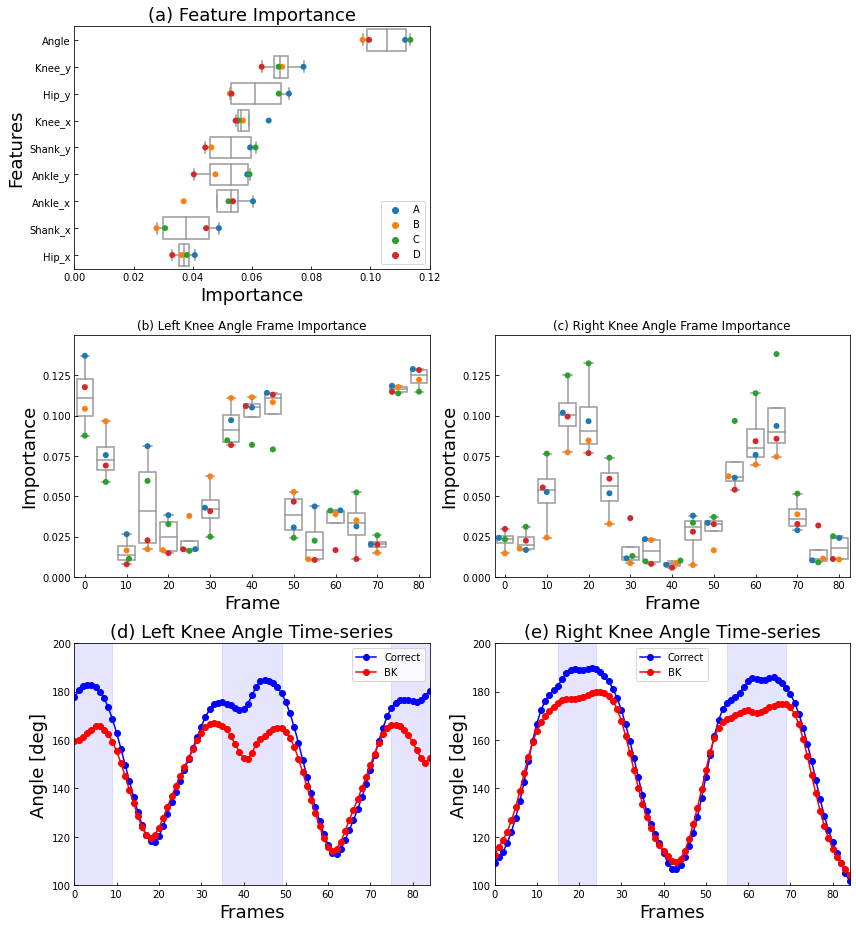

In [3]:
lim = 0.15
X = [x for x in range(85)]
coef_lst = np.array(coef_lst)

bk_num, correct_num = bk_data.shape[0], correct_data.shape[0]
bk = bk_data.reshape(bk_num, 85, 9, 2)
correct = correct_data.reshape(correct_num, 85, 9, 2)
bk_langle_mean = bk[:, :, 8, 0].mean(axis=0)
bk_rangle_mean = bk[:, :, 8, 1].mean(axis=0)
correct_langle_mean = correct[:, :, 8, 0].mean(axis=0)
correct_rangle_mean = correct[:, :, 8, 1].mean(axis=0)

fig = plt.figure(figsize=(12,13))
ax0 = plt.subplot(321)
ax1 = plt.subplot(323)
ax2 = plt.subplot(324)
ax3 = plt.subplot(325)
ax4 = plt.subplot(326)

coef_dict = {'Hip_x': coef_lst[:, :, 0, 0] + coef_lst[:, :, 1, 0],
            'Hip_y': coef_lst[:, :, 0, 1] + coef_lst[:, :, 1, 1],
            'Knee_x': coef_lst[:, :, 2, 0] + coef_lst[:, :, 4, 0],
            'Knee_y': coef_lst[:, :, 2, 1] + coef_lst[:, :, 4, 1],
            'Shank_x': coef_lst[:, :, 3, 0] + coef_lst[:, :, 5, 0],
            'Shank_y': coef_lst[:, :, 3, 1] + coef_lst[:, :, 5, 1],
            'Ankle_x': coef_lst[:, :, 6, 0] + coef_lst[:, :, 7, 0],
            'Ankle_y': coef_lst[:, :, 6, 1] + coef_lst[:, :, 7, 1],
            'Angle': coef_lst[:, :, 8, 0] + coef_lst[:, :, 8, 1]}

labels = []
models = []
importance = []
for k, v in coef_dict.items():
    imp = v.sum(axis=1) / 85
    labels.extend([k for _ in range(len(imp))])
    models.extend([chr(65+i) for i in range(len(imp))])
    importance.extend(imp)
data = pd.concat([pd.DataFrame(labels), pd.DataFrame(importance)], axis=1)
data = pd.concat([data, pd.DataFrame(models)], axis=1).set_axis(['Features', 'Importance', 'Model'], axis=1)
order = ['Angle', 'Knee_y', 'Hip_y', 'Knee_x', 'Shank_y', 'Ankle_y', 'Ankle_x', 'Shank_x', 'Hip_x']
data['order'] = data['Features'].apply(lambda x: order.index(x) if x in order else -1)
data = data.sort_values(by=['order', 'Model']).reset_index(drop=True).drop(columns='order')

sns.boxplot(x="Importance", y="Features", data=data, ax=ax0, color='white', showfliers=False)
sns.stripplot(x="Importance", y="Features", data=data, ax=ax0, size=6, jitter=False, hue='Model')
ax0.set_xlabel('Importance', fontsize=18)
ax0.set_ylabel('Features', fontsize=18)
ax0.legend(loc='lower right')
ax0.set_title('(a) Feature Importance', fontsize=18)
ax0.set_xlim(0, 0.12)

coef_dict = {'LKnee_y': coef_lst[:, :, 2, 1],
            'RKnee_y': coef_lst[:, :, 4, 1],
            'LAngle': coef_lst[:, :, 8, 0],
            'RAngle': coef_lst[:, :, 8, 1]}
key = 'LAngle'
labels = []
models = []
importance = []
for i, v in enumerate(coef_dict[key].reshape(coef_dict[key].shape[0], 17, 5).sum(axis=2)/5):
    labels.extend([j for j in range(len(v))])
    models.extend([chr(65+i) for _ in range(len(v))])
    importance.extend(v)
data = pd.concat([pd.DataFrame(labels), pd.DataFrame(importance)], axis=1)
data = pd.concat([data, pd.DataFrame(models)], axis=1).set_axis(['frame', 'importance', 'Model'], axis=1)

sns.boxplot(x="frame", y="importance", data=data, ax=ax1, color='white', showfliers=False)
sns.swarmplot(x="frame", y="importance", data=data, ax=ax1, size=6, hue='Model')
ax1.set_ylabel('Importance', fontsize=18)
ax1.set_xlabel('Frame', fontsize=18)
ax1.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax1.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax1.set_yticks([0, 0.025, 0.05, 0.075, 0.10, 0.125])
ax1.set_ylim(0, lim)
ax1.set_title('(b) Left Knee Angle Frame Importance')
ax1.legend()
ax1.get_legend().remove()

key = 'RAngle'
labels = []
models = []
importance = []
for i, v in enumerate(coef_dict[key].reshape(coef_dict[key].shape[0], 17, 5).sum(axis=2)/5):
    labels.extend([j for j in range(len(v))])
    models.extend([chr(65+i) for _ in range(len(v))])
    importance.extend(v)
data = pd.concat([pd.DataFrame(labels), pd.DataFrame(importance)], axis=1)
data = pd.concat([data, pd.DataFrame(models)], axis=1).set_axis(['frame', 'importance', 'Model'], axis=1)

sns.boxplot(x="frame", y="importance", data=data, ax=ax2, color='white', showfliers=False)
sns.swarmplot(x="frame", y="importance", data=data, ax=ax2, size=6, hue='Model')
ax2.set_ylabel('Importance', fontsize=18)
ax2.set_xlabel('Frame', fontsize=18)
ax2.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax2.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax2.set_yticks([0, 0.025, 0.05, 0.075, 0.10, 0.125])
ax2.set_ylim(0, lim)
ax2.set_title('(c) Right Knee Angle Frame Importance')
ax2.legend()
ax2.get_legend().remove()

ax3.plot(X, correct_langle_mean, marker='o', label='Correct', c='blue')
ax3.plot(X, bk_langle_mean, marker='o', label='BK', c='red')
ax3.legend()
ax3.axvspan(0, 9, color='blue', alpha=0.1)
ax3.axvspan(35, 49, color='blue', alpha=0.1)
ax3.axvspan(75, 84, color='blue', alpha=0.1)
ax3.set_ylim(100, 200)
ax3.set_xlim(0, 84)
ax3.set_xlabel('Frames', fontsize=18)
ax3.set_ylabel('Angle [deg]', fontsize=18)
ax3.set_title('(d) Left Knee Angle Time-series', fontsize=18)

ax4.plot(X, correct_rangle_mean, marker='o', label='Correct', c='blue')
ax4.plot(X, bk_rangle_mean, marker='o', label='BK', c='red')
ax4.legend()
ax4.axvspan(15, 24, color='blue', alpha=0.1)
ax4.axvspan(55, 69, color='blue', alpha=0.1)
ax4.set_ylim(100, 200)
ax4.set_xlim(0, 84)
ax4.set_xlabel('Frames', fontsize=18)
ax4.set_title('(e) Right Knee Angle Time-series', fontsize=18)
ax4.set_ylabel('Angle [deg]', fontsize=18)

fig.tight_layout()